# Model description
## (this model is still being recommited in Kaggle, no idea about the progress , I will recommit the new version)

This was a model we trained on different preprocessing pipelines,
to find out how they compared.
The best results were on images that have been preprocessed by contrast limited adaptive histogram equalization (CLAHE), cropping, masking and padding with 128 level gray or by a technique inspired by Benjamin Graham,
read more [here](https://github.com/rozni/uni-ml/blob/master/Cognitive_Systems_for_Health_Technology_Applications/Case_2/Image_Preprocessing.ipynb)
or see the [full report](https://github.com/rozni/uni-ml/tree/master/Cognitive_Systems_for_Health_Technology_Applications/Case_2). 

Even though, artificial neural networks are great in making linear combinations
on their own, we thought of helping them, in this case, the model was trained
on images preprocessed by the CLAHE method mentioned above and then converted to grayscale.
That improved the training speed twice (there is 3 times fewer input values).
We also tried to use YCrCb and HSL colorspaces, they performed just as good
as ordinary RGB (although, YCrCb seemed pick up on features a little earlier).
This grayscale  was interesting because of the faster training
starting to recognize feautres much earlier compared to RGB (about 5 epochs),
we have not found out when would RGB took over.

This model was reached about 70% accuracy on
a balanced subset of the dataset (18 000 samples, we trained on equal amount of eyes with and without symptoms for easier assesment), which was some of the best we achieved.

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import keras
from keras import layers, regularizers

Using TensorFlow backend.


In [2]:
BASE_DIR = '../input/'
TRAIN_DIR = '500x500_cropped_clahe_128/500x500_cropped_clahe_128/'
TARGET_SIZE = (300, 300)

In [3]:
# design the model
model = keras.models.Sequential()

model.add(layers.InputLayer((*TARGET_SIZE, 1)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(32, (3,3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(32, (3,3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(64, (3,3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(64, (3,3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(128, (3,3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(128, (3,3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
 
model.add(layers.Conv2D(256, (3,3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(256, (3,3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
          
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=['acc']
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 300, 300, 1)       4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 298, 298, 32)      320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 298, 298, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 298, 298, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 296, 296, 32)      9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 296, 296, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 296, 296, 32)      0         
__________

In [4]:
# load the labels and balance teh training set

labels_df = pd.read_csv(os.path.join(BASE_DIR, 'labels.csv'))

# balance classes
fifty_fifty_subset = pd.concat([
    labels_df[labels_df['class']=='symptoms'].sample(n=9000, random_state=0),
    labels_df[labels_df['class']=='nosymptoms'].sample(n=9000, random_state=0)
]).sample(frac=1.0, random_state=0) # shuffle

# training/validation split (70% to 30%)
split = 70*len(fifty_fifty_subset)//100
train_df = fifty_fifty_subset.iloc[:split]
valid_df = fifty_fifty_subset.iloc[split:]

In [5]:
# setup image generators

common_flow_kwargs = dict(
    directory=os.path.join(BASE_DIR, TRAIN_DIR),
    x_col='file_name',
    y_col='class',
    target_size=TARGET_SIZE,
    batch_size=50,
    class_mode='binary',
    color_mode='grayscale',
)

train_gen = keras.preprocessing.image.ImageDataGenerator(
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255,
).flow_from_dataframe(
    dataframe=train_df,
    **common_flow_kwargs,
)

valid_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
).flow_from_dataframe(
    dataframe=valid_df,
    **common_flow_kwargs,
)

Found 12600 images belonging to 2 classes.
Found 5400 images belonging to 2 classes.


In [6]:
# train the model
history = model.fit_generator(
      train_gen,
      steps_per_epoch=train_gen.n//train_gen.batch_size,
      epochs=25,
      validation_data=valid_gen,
      validation_steps=valid_gen.n//valid_gen.batch_size,
)

# save the model just in case
model.save('grayscale-clahe.h5')

Epoch 1/25
252/252 [==============================] - 311s 1s/step - loss: 0.7862 - acc: 0.5088 - val_loss: 0.7399 - val_acc: 0.5041
Epoch 2/25
252/252 [==============================] - 290s 1s/step - loss: 0.7363 - acc: 0.5105 - val_loss: 0.7119 - val_acc: 0.5135
Epoch 3/25
252/252 [==============================] - 290s 1s/step - loss: 0.7221 - acc: 0.5057 - val_loss: 0.7045 - val_acc: 0.5133
Epoch 4/25
252/252 [==============================] - 290s 1s/step - loss: 0.7131 - acc: 0.5156 - val_loss: 0.7008 - val_acc: 0.5204
Epoch 5/25
252/252 [==============================] - 290s 1s/step - loss: 0.7113 - acc: 0.5200 - val_loss: 0.6934 - val_acc: 0.5267
Epoch 6/25
252/252 [==============================] - 290s 1s/step - loss: 0.7072 - acc: 0.5235 - val_loss: 0.6969 - val_acc: 0.5343
Epoch 7/25
252/252 [==============================] - 290s 1s/step - loss: 0.7013 - acc: 0.5266 - val_loss: 0.6886 - val_acc: 0.5387
Epoch 8/25
252/252 [==============================] - 290s 1s/step - 

## Results

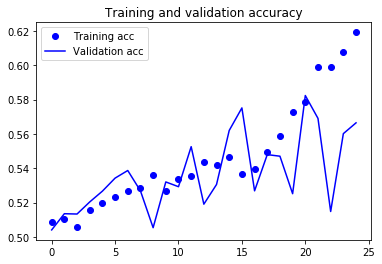

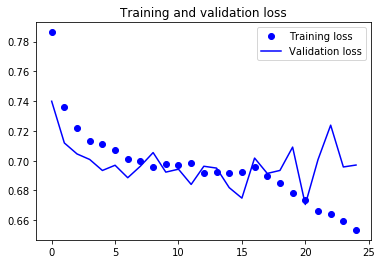

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()